# Lab 1: Where Do Embeddings Come From?

## Overview
Throughout this class we will be making heavy use of embeddings of one sort or another. This lab will work through how word embeddings can be generated. We will also examine how semantic information appears to be captured in the various dimensions of the trained embeddings.

## Goals
By the end of this lab you should:

 * Understand what an embedding is
 * Understand how skipgrams are used
 * Understand the basics of working with a corpus of text
 * Be able to generate skipgram data from a corpus
 * Understand what "tokenization" means
 * Be able to tokenize input data

## Estimated Time: 60 minutes

One of the most basic yet most important insights to have regarding machine learning is that it's all math. This turns out to have some very important consequences. If we are working with something like temperature sensors or other numeric data sources, this can feel very natural. What would this mean for working with text, though?

This question is particularly relevant since the overarching goal of this course is to learn how to use generative AI based large language models (LLMs) to solve useful problems. Since we are working with natural language data sources, we must be concerned about how to represent words as numbers. How do we encode the textual information in a way that will allow us to apply mathematics techniques in a useful way? In this lab we will consider what has become the most common technique: Embeddings.

In this lab we will generate simple word embeddings. In the remainder of the class we will be leveraging other types of embeddings, but the creation and training of these other embeddings is significantly more effort, though based on the concepts that we will consider here. In the end, all embeddings take input data and represent the data as some (usually high) dimensional vector coordinate.

## What is a Vector?

For our purposes, you can think of a vector as an ordered list of numbers. If you're a programmer this likely makes you think of an array (or list). This is good intuition, but it might serve us well to think of this a bit more mathematically. What is your intuitive understanding of each of the following:

### Python List:
```
values = [1, 5, -2]
```

### A Point in Space:
$
p = (1, 5, -2)
$

Both the variable `values` in the Python code and the variable $p$ in the mathematics expression hold the same information. It is likely, though, that the second representation makes you envision some point in three dimensional space.

This means that an embedding is simply a "vector representation," or a numeric coordinate in some high dimensional space. Thought of programmatically the embedding is an ordered list of values used to stand in for the input data.

Where do these embedding vectors come from? What do we mean by high dimensional space? We will answer that question in the lab below.

# <img src="../images/task.png" width=20 height=20> Task 1.1

We will need various libraries to complete the lab ahead. Specifically, we need to import:

* NumPy, a numeric processing library for Python. The conventional alias for this library is `np`.
* TensorFlow, a machine learning library distributed by Google. The conventional alias for this library is `tf`.
* From the `tensorflow.keras` library, another package embedded within TensorFlow, the `layers` and `models` packages.
* The `os` library so that we can enumerate files and directories easily.
* The `tiktoken` library, a library for representing textual data in a tokenized form.

Please use the cell below to import these libraries and packages:

**Note:** *TensorFlow will very likely generate some informational messages when you import it and, later, when you first use it. This is completely expected. Even though they appear in red, they are not errors.*

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
import tiktoken
import os

2024-11-25 17:05:54.470874: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-25 17:05:54.478838: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-25 17:05:54.488127: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-25 17:05:54.490891: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-25 17:05:54.497681: I tensorflow/core/platform/cpu_feature_guar

# <img src="../images/task.png" width=20 height=20> Task 1.2

## Tokenization

We mentioned in the introduction that machine learning is all mathematics and requires that we represent our problem as numbers. Where do these numbers come from? How are they generated? This is where *tokenization* comes into play.

Very simply, the tokenization process will take the input data and convert it into some kind of numeric representation. Before we describe how the specific value used for any particular input word is generated, it is important for you to understand that the actual value used to represent any particular word *is absolutely not important.* What is important is that the same input data will produce the same numeric output from the tokenizer; that's it.

People are often somewhat lazy when describing the tokenization process. We've already been a bit lazy, or at least high level, in our description. While the ultimate goal is to convert the input data into a numeric representation, there are actually several things happening along the way. The two most important and universal steps are:

 * Assuming that the input data is text, split the input text into arbitrary chunks. A simple example might be to take an input string such as `"Too many secrets"` and split it into words: `['Too', 'many', 'secrets']`.
 * Assign a unique value to each of the elements generated when the input data is split. These values are *tokens*, which stand in for the original data.

Let's stand back and think about this for a minute. Let's imagine that we have a sentence like:

`"I'm sorry Dave, I can't do that."`

If our tokenization approach splits this input data on spaces to find words, we would have something like seven unique words... but think of some consequences of splitting on spaces. What would the words be? We would have the list:

`['I'm', 'sorry', 'Dave,', 'I', 'can\'t', 'do', 'that.']`

Notice the words `'Dave,'` and `'that.'` Do you see how the punctuation has come along with the word? A direct consequence of this is that the word `'that'` will appear multiple times in our table of unique words!  Why? Because it might be `'that'`, or `'that,'`, or `'that.'`, or `'that!'`, etc. Are these *really* different words? No! You still might be asking yourself, "So what?"

The tokens that we generate will ultimately be used to train a neural network in such as away as to find semantic relationships between the tokens. If we have one word represented ten different ways, this task becomes very difficult. This might make you think, "Then let's just strip out the punctuation." This certainly can be done, but this too has consequences. Especially since our goal is to work with Large Language Models and generate text, if our models do not understand punctuation (because it has been stripped out) our generated text will not be amazing.

There's another consequence of this approach that is related to how we assign a unique numeric value as each token. If we have 10,000 unique tokens, we will require 10,000 unique values. If we have 10,000,000 unique tokens, we will need 10,000,000 unique values. Unless you have already worked with the training of word embeddings or representing text for neural network processing, it might not be obvious to you why this is a potential problem; for now let's just say that it would be ideal to limit the number of unique tokens to some number that is as small as possible. (More on this later!)

### TikToken

In our labs we will be leveraging the `tiktoken` library. This tokenization library is described as a Byte-Pair Encoding (BPE) library, though this description might not be ideally true. A BPE literally encodes pairs of bytes; tiktoken is more complicated than that.

The tiktoken library supports many encoding and splitting variants which can be selected or which can be used to generate your own BPE style tokenizer. For most if not all of these labs we will use the `cl100k_base` tiktoken tokenizer, which is the tokenizer used by GPT-4. This tokenizer uses an approach that generates unique values for the most common words (or "byte pairs", using the word "pairs" loosely). In addition to these, less common words are often broken into smaller tokens (literally byte pairs). Consider the following string and the resulting tokens:

`"I'm sorry Dave, I can't do that."` becomes `["I", "'m", " sorry", " Dave", ",", "I'", " can", "'t", " do", " that", "."]`

On the one hand, tiktoken takes our string which is comprised of seven words produces eleven unique tokens. In other words, there are more pieces. On the other hand, notice that we now have single tokens that represent the words "can" and "I" and the remaining pieces of that are small pieces that can be added on.

Let's start writing some code:

 * Using the following cell, call the `get_encoding()` function from the `tiktoken` package. When you call `get_encoding()` you can pass in a tokenizer configuration. We would like to load the `'cl100k_base'` configuration. Assign this tokenizer to a variable named `tokenizer`.
 * After loading the tokenizer, use the `encode()` function to encode the string, "The lady doth protest too much, methinks." What is produced by the encoder?
 * Using the values returned by the tokenizer from the last step, use the `decode_tokens_bytes()` call to decode the values back to a list of the original text values.

In [2]:
tokenizer = tiktoken.get_encoding("cl100k_base")
tokens = tokenizer.encode("The lady doth protest too much, methinks.")
print(tokens)
print(tokenizer.decode_tokens_bytes(tokens))

[791, 17240, 656, 339, 8835, 2288, 1790, 11, 21747, 15872, 13]
[b'The', b' lady', b' do', b'th', b' protest', b' too', b' much', b',', b' meth', b'inks', b'.']


Notice how the string has been split up. Words such as "lady", "The", and "protest" are all split out as separate terms. The far less common words "methinks" has been broken into `["meth", "inks"]` and "doth" has become `["do", "th"]`.

# <img src="../images/task.png" width=20 height=20> Task 1.3

Let's think about how this approach helps limit the number of unique values. Whenever you load a tiktoken tokenizer, you can use the `n_vocab` attribute on the tokenizer to determine how many unique tokens can ever be generated by the tokenizer.

Use the following cell to assign the value in `tokenizer.n_vocab` into a variable named `vocab_size`. How many unique tokens are possible in this tokenizer?


In [3]:
vocab_size = tokenizer.n_vocab
vocab_size

100277

This means that there are 100,277 different possible tokens. These tokens will be generated based on whatever text you ask it to encode. If you want to experiment, you could try decoding some really large numbers! In fact, let's try that.

# <img src="../images/task.png" width=20 height=20> Task 1.4

Use the following cell to call `decode_tokens_bytes` on the `tokenizer` object for tokens numbered from 100,000 through 100,009.

In [4]:
tokenizer.decode_tokens_bytes([i for i in range(100000,100010)])

[b'IClient',
 b'ISODE',
 b'Issuer',
 b')}\r\n',
 b',but',
 b' Uph',
 b'(Sub',
 b' t\xc3\xa9l\xc3\xa9phone',
 b' onDataChange',
 b' marshaller']

# <img src="../images/task.png" width=20 height=20> Task 1.5

Now that we have the tokenizer ready to go, we need a *corpus* of text to work with. Corpus is a latin word that literally translates as *body*. The corpus of text is the body of text we will use to train our model.

In our case, we will use just one file as our corpus. This file contains an extract of 2,000,000 lines of text composed of more than 16 million words (not unique words!) from an arbitrary composite of parts of 45 different books from the public Project Gutenberg repository of free text. If you look at the text, you will find that some of these are non-fiction, some are fiction, some are books of facts and figures, etc.

What we need to do is create some way of loading and preparing this text in a way that it can be used to train word embeddings. This involves a fair amount of preprocessing. Rather than provide you with a prebuilt dataset, we want to walk you through *how that dataset would be created* so that you could potentially build your own dataset from your own data if the need arises.

With this in mind, we are going to write a *generator function*, which is a special type of Python function, to act as our data source. Also, even though we have only a single text file, we are going to write our generator such that it could support a directory full of different text files, which is much more typical when building a corpus of text data.

## Generators vs. Functions

A function in Python, as you surely know, encapsulates some functionality into an easy to use callable "package." For example:

```
def average(data):
    if len(data) < 1:
        return "Undefined."
    sum = sum(data)
    average = sum / len(data)
    return average
```

The function above accepts a list of numbers as input and returns the average value based on that list. There's nothing complicated about this code. By turning this into a function, we now have an easy way to obtain the average value of a list with a single line of code:

```
print(f'The average is {average(data)}')
```

So then, a function allows us to refactor code in such a way as to make our code more readable overall. Functions are also important in that we can take a piece of code that we reuse many times in a project and refactor it into a single function. This allows us to make changes to that code in one place and benefit from those changes in all places the function is called.

When we call a function in Python, the data in that function is only "in scope," which for our purposes we might think of as "kept in memory" or as "available."  Consider the following function:

```
def fun():
    x = 1
    while True:
        x = x * 2
        return x

for i in range(10):
    print(fun())
```

What would you predict will be printed? We can see that the `fun()` function has an infinite `while` loop in it, but because of the `return x` statement, the loop will actually terminate at the end of the first pass. What value will it return the first time? At the end of the first pass, `x` is `2`. This is all fine, but what happens the *second time* we call that function? What will be printed? If you're not sure, try it for yourself. Verify for yourself that this function will return `2` *every time it is called!* Why? Because the variable `x` that lives inside of `fun()` is only in scope and allocated in memory *while the function is executing.*

Let's make a very small change to our function:

```
def fun():
    x = 1
    while True:
        x = x * 2
        yield x

my_fun = fun()
for i in range(10):
    print(next(my_fun))
```

You may notice that we have changed more than one thing in the code above, but the function itself has only one tiny change; we have replaced the word `return` with the word `yield`. What does this do?

First, if you attempt to call `fun()` now, you will not get a value back. Instead, it will tell you that a *generator object* has been returned. This means that it has not called the *function*, it has created an *object*. What made this happen? Simply replacing `return` with `yield`.

So what? How is this helpful? How do we get values out of it? To get values out of this object, we need to use the `next()` function to request a value from this generator, which is effectively a custom *iterable*. What changes in terms of output is that the output of the loop will now be:

```
2
4
8
16
32
64
128
256
512
1024
```

The reason this changes is that the variable inside of the generator object is maintained in memory until the variable pointing to that instance of the generator goes out of scope.

Still, you might be wondering why we wouldn't just use a list comprehension to generate the values. This is a fair question with a simple answer. If we generate this data with a list comprehension, all of the computation is done up front and all of the data is then held in memory in a single list. This is absolutely faster... but requires that we can hold all of the data in memory. If you are thinking of a list of 100, 1,000, or even 1,000,000 values, no problem... but what if we're talking about holding 100,000,000,000 64-bit values in memory. This will require more than 400 gigabytes of RAM! This is where generators come in.

Data from a generator is generated *just in time*. While the generator will take more time to generate the same number of values, we never need to hold more than the code for the generator, the current value of `x`, and the returned value in memory at any given time. This potentially allows us to generate data of infinite length without needing to hold infinity in memory.

### Let's Write Some Code

Using the following cell, create a generator function that will:

 * Find all files whose names end with `.txt` in the directory `../data`.
 * Iterate over the files in that directory. For each file:
   - Convert the file to a list of tokens using the tokenizer.
   - Yield each token back from the generator.
 * Test your generator by instantiating it. Then generate and print the first ten tokens.

In [5]:
input_directory = '../data'

def generate_data():
    files = os.listdir(input_directory) # Get a list of the files in the directory
    files = [i for i in files if i[-4:]=='.txt'] # Filter out files that do not end with .txt
    for file in files:
        print(f'Opening file {file}.')
        with open(os.path.join(input_directory, file), 'r', encoding='utf-8') as f:
            tokens = tokenizer.encode(f.read().lower())
        for token in tokens:
            yield token

generator = generate_data()  # Instantiate a generator
for i in range(10):
    print(next(generator)) 

Opening file xal.txt.
256
220
15
13437
27907
80944
512
256
220
9748


# <img src="../images/task.png" width=20 height=20> Task 1.6

At this point we have a working generator that generates tokens for us. This is *close* to what we need, but not quite right. To train our embeddings, our generator needs to generate two values; we need to generate what we think of as an `x` value, or the input value to the neural network, and a `y` value, which is the expected output (also called label or target) from the network.

What we have written so far is effectively returning the value of `x`. What we need to add is the value for `y`. What should this value be? The first approach we are going to consider for building word embeddings takes an input word (or token) and attempts to predict what the next token should be.

Copy and paste your generator function above into the cell below and adjust it so that it yields pairs of values, `x` and `y`, as described above. Once you have adjusted your code, print out the first ten pairs of `x` and `y` values.

In [6]:

def generate_data():
    files = os.listdir(input_directory)
    files = [i for i in files if i[-4:]=='.txt']
    for file in files:
        print(f'Opening file {file}.')
        with open(os.path.join(input_directory, file), 'r', encoding='utf-8') as f:
            tokens = tokenizer.encode(f.read().lower())
        num_tokens = len(tokens) # How many tokens do we have?
        for current_position, token in enumerate(tokens): # enumerate the tokens so we know where we are
            # We need to return each word as x and the next word as y. This means that we need
            # to loop to num_tokens - 1 since we cannot predict the word that comes after the end!
            if(current_position >= (num_tokens - 1)):
                continue
            x = token # The current token is x
            y = tokens[current_position + 1] # The next token is y
            yield x, y
            
generator = generate_data()  # Instantiate a generator
for i in range(10):
    print(next(generator)) 

Opening file xal.txt.
(256, 220)
(220, 15)
(15, 13437)
(13437, 27907)
(27907, 80944)
(80944, 512)
(512, 256)
(256, 220)
(220, 9748)
(9748, 13437)


# <img src="../images/task.png" width=20 height=20> Task 1.7

There's just one more change we need to make to our yielded values before we are ready to turn this into a TensorFlow dataset and build a model. While we could leave our `y` value as an integer, it is much more typical to *one-hot encode* this value.

One-hot encoding means that we will generate a vector that is as wide as the total number of possible outputs and set just one position in that vector, or array, to `1`. In other words, only one position in that vector is "on" or "hot."

Copy and paste your current generator into the cell below and adjust it such that the `y` value is returned as a one-hot encoded vector where the position that aligns with the value of `y` is turned on. Print out the first `x` and `y` values.

In [7]:

def generate_data():
    files = os.listdir(input_directory)
    files = [i for i in files if i[-4:]=='.txt']
    for file in files:
        print(f'Opening file {file}.')
        with open(os.path.join(input_directory, file), 'r', encoding='utf-8') as f:
            tokens = tokenizer.encode(f.read().lower())
        num_tokens = len(tokens) # How many tokens do we have?
        for current_position, token in enumerate(tokens): # enumerate the tokens so we know where we are
            # We need to return each word as x and the next word as y. This means that we need
            # to loop to num_tokens - 1 since we cannot predict the word that comes after the end!
            if(current_position >= (num_tokens - 1)):
                continue
            x = token # The current token is x
            y = tokens[current_position + 1] # The next token is y
            vector = np.zeros(vocab_size) # Create a vector of zeros that is num_tokens wide
            vector[y] = 1 # Turn the position matching the value of y on
            yield x, vector
            
generator = generate_data()  # Instantiate a generator
for i in range(1):
    x, y = next(generator)
    print(x, y)
print(y.argmax())

Opening file xal.txt.
256 [0. 0. 0. ... 0. 0. 0.]
220


# <img src="../images/task.png" width=20 height=20> Task 1.8

## Creating a TensorFlow Dataset

Now that we have a functioning generator that can generate pairs of token numbers, we are ready to turn our attention to the TensorFlow side of the equation. We have three main tasks:

 1. Create a TensorFlow Dataset object fed by the generator.
 2. Create the neural network to train the embeddings.
 3. Train the network.

Conveniently, TensorFlow provides a wonderful Dataset interface that allows you to feed networks from a variety of sources pretty easily. Since we have built a generator function, we want to leverage the `from_generator()` function, which allows us to describe how our generator functions and wrap a Dataset interface around it.

The way that we do this is by calling `tf.data.Dataset.from_generator()`, where `tf` represents the TensorFlow package that we imported. There are a few peculiarities to creating this dataset that we need to discuss.

The first expected argument is intuitive; we need to give it the name of the generator function that we have created. Since we have named our generator function `generate_data`, this is the name that we pass as the first parameter.

The `from_generator()` interface also requires that we tell it what the data will look like. In all honesty, the way this interface works feels overly complicated. Certainly, it will allow us to do some cool and complex things, but for the basic use case, which is a generator that returns an `x` and a `y` value, it feels as though the function could leverage the Python introspection (ability for Python and Python objects to inspect themselves) to automatically determine what the output of the generator looks like. Unfortauntely, this is not the case. We must tell the `from_generator()` function what our generator will generate.

To do this we will make use of the `output_signature` keyword argument in the `from_generator()` call. When using this argument, we *absolutely must* describe the values returned using a Python tuple. Not a list. Not a dictionary. Not a set. It *must* be a tuple.

Each member of the tuple must describe one of the outputs. In our case, our generator returns two values, `x` and `y`. The `x` value is a simple, single, integer value, which could also be described as a *scalar*. The `y` value, on the other hand, is an array (a NumPy array, specifically) that is the same width as the number of possible tokens.

To describe these in the `output_signature` argument, we have to use the TensorFlow `TensorSpec` object. We will very simply describe a *tensor* as an ordered list of values, or a vector (as defined above). The `TensorSpec` class allows you to *describe* a tensor as opposed to *create* a tensor.

For our use, we must use `TensorSpec` in the following way:
 * We must describe the shape of each value using the `shape` keyword argument.
 * We must define the data type of each value using the `dtype` keyword argument.

As an example, if our generator returned an `x` value that is a $4x8$ matrix of integer values and a `y` value that is a single floating point value, we might describe it as follows:

```
ds = tf.data.Dataset.from_generator(
    my_generator,
    output_signature=(
      tf.TensorSpec(shape=(4,8), dtype=tf.int32),
      tf.TensorSpec(shape=(), dtype=tf.float64)
    ) ) # Close the tuple then close the function call
```

Please execute the cell below to define a variable named `ds`. Use this variable to hold a `Dataset` using the `from_generator()` function using an `output_signature` that matches the data our generator produces.

In [8]:
ds = tf.data.Dataset.from_generator(
    generate_data,
    output_signature=(
        tf.TensorSpec(shape=(), dtype=tf.int32),
        tf.TensorSpec(shape=(vocab_size,), dtype=tf.int32)
    )
)


I0000 00:00:1732554621.775717      85 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-11-25 17:10:21.792812: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


# <img src="../images/task.png" width=20 height=20> Task 1.9

We now have a dataset. Currently, if we were to try to use the dataset, it would give us one `x, y` pair at a time. The bad news is that neural networks are not designed to accept just one input at a time; they expect to receive *batches* or groups (or arrays) of samples. There is good news, though! We can modify our dataset very easily to return batches of pairs. This can be accomplished as follows:

```
ds = ds.batch(32)
```

What this says is, "Take the `ds` we currently have and wrap it inside of a batching process that returns batches of 32 values. Assign this batched version back to `ds`."

Please use the cell below to change our `ds` to return batches of 16 pairs. Please ignore any warnings or informational messages that might be generated!


In [9]:
ds = ds.batch(16)
for i in ds.take(1):
    print(i)


Opening file xal.txt.
(<tf.Tensor: shape=(16,), dtype=int32, numpy=
array([  256,   220,    15, 13437, 27907, 80944,   512,   256,   220,
        9748, 13437, 27907, 58412,  8349,   512,   256], dtype=int32)>, <tf.Tensor: shape=(16, 100277), dtype=int32, numpy=
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)>)


2024-11-25 17:10:48.682543: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


# <img src="../images/task.png" width=20 height=20> Task 1.10

The time has come for us to build and train our neural network, which results in training our embeddings. The code in the cell below does several things. Within our class, we really aren't learning how to build neural networks; that's what SEC595 is all about. To use LLMs, we really don't need to build neural networks, either. We may find ourselves wanting to work with and process a corpus of text, which is why we have covered the material so far at the level of detail above. For the code below, we suggest that you consider the high level description below and then read through the code in the following cell before you run it to get an idea of what is happening.

 * We define a Keras callback named `StopOnAccuracy` that is used to monitor the network during training. At the end of each epoch, or training pass, it will check to see if the network has achieved some accuracy threshold. If it has, the callback will halt the training.
 * We instantiate the `StopOnAccuracy` callback class, setting the threshold accuracy to 0.24. Why this number? Why would an accuracy of 25% be good enough? The answer is partly related to the dataset we have and partly related to the task we are asking the network to solve. We are asking the network to accept a token and then predict which of the more than 100,000 possible tokens most likely comes next. While we would love to see an accuracy in excess of 90%, an accuracy of 24% is actually quite good. Think about it; if our network were just making random guesses, the expected accuracy would be around 0.00099%. Put another way, it is a 1:100,277 chance that the correct token is selected. Clearly, 24% is an *amazing* result.
 * Define a neural network that accepts a single input, generate an embedding vector, and then attempts to predict the correct one-hot encoded next token output.
   - The embedding layer will generate a 2 dimensional value. *This is incredibly small.* In practice, this would be a value of 512 or larger. We are choosing to use this extremely small value so that we can look at the output visually using a graph.
   - The final layer of the neural network makes use of the `softmax` activation function. This function takes the array of outputs and maps it into a single probability distribution that sums to 1.0. This allows us to look at the output as a probability and simply select the position with the highest value, where each position represents a single possible token.

In [10]:
class StopOnAccuracy(tf.keras.callbacks.Callback):
    def __init__(self, point):
        super(StopOnAccuracy, self).__init__()
        self.point = point

    def on_epoch_end(self, epoch, logs=None): 
        accuracy = logs["accuracy"]
        if accuracy >= self.point:
            self.model.stop_training = True

callbacks = [StopOnAccuracy(0.24)] # <- set optimal point

model = models.Sequential()
model.add(layers.Input(shape=()))
model.add(layers.Embedding(vocab_size, 2, embeddings_initializer='glorot_uniform'))
model.add(layers.Dense(vocab_size, activation='softmax'))


# <img src="../images/task.png" width=20 height=20> Task 1.11

Let's take a moment to pause and reflect on a choice we made earlier. When discussing tokenization we mentioned that we were choosing to use tokens rather than using each unique word because it would limit the overall size of things. We're in a position now to better understand what that means.

Use the following cell to call `model.summary()`.

In [11]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 2)              │       200,554 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100277)         │       300,831 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 501,385 (1.91 MB)

 Trainable params: 501,385 (1.91 MB)

 Non-trainable params: 0 (0.00 B)

# <img src="../images/task.png" width=20 height=20> Task 1.12

Notice that our network has just over a half million parameters that need to be trained. While these may seem like a lot, it truly isn't. What if we had chosen to use the most common million words to build our network? That would require 3,000,000 parameters. What if we stick with using the 100,000+ tokens but we used a more reasonable embedding size of, say, 512? That very simple network would require more than 100,000,000 parameters!!! This should give you some sense of why LLMs typically have *billions* of paramters (this results not only from the size of the embedding, which certainly is a major contributor, but also to using these high dimensional embeddings in much more complex networks).

Our next step is to compile and train the model. Please execute the following cell to accomplish this:


In [12]:
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])
training_history = model.fit(ds, epochs=300, steps_per_epoch=200, callbacks=callbacks)

Epoch 1/300
Opening file xal.txt.
200/200 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.0701 - loss: 11.4777
Epoch 2/300
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.0681 - loss: 11.2332
Epoch 3/300
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.0735 - loss: 10.9153
Epoch 4/300
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.0584 - loss: 10.4326
Epoch 5/300
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.0658 - loss: 9.8952
Epoch 6/300
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.0616 - loss: 8.9831
Epoch 7/300
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.0584 - loss: 8.9769
Epoch 8/300
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.0664 - loss: 8.4192
Epoch 9/300
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.0604 - loss: 7.5379
Epoch 10/300
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.0800 - loss: 6.3371
Epoch 11/300
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.1044 - loss: 5.4472
Epo

# <img src="../images/task.png" width=20 height=20> Task 1.13

It would be nice to take a look at how the training went. The following cell contains some `matplotlib` code that will render a graph of the *loss* and the *accuracy*. 

Loss is a fairly technical term used to describe how much information is being lost when making predictions. We will often react to increasing loss values because it tends to imply the network is no longer learning properly. 

Accuracy allows us to track how the accuracy varies from epoch to epoch.

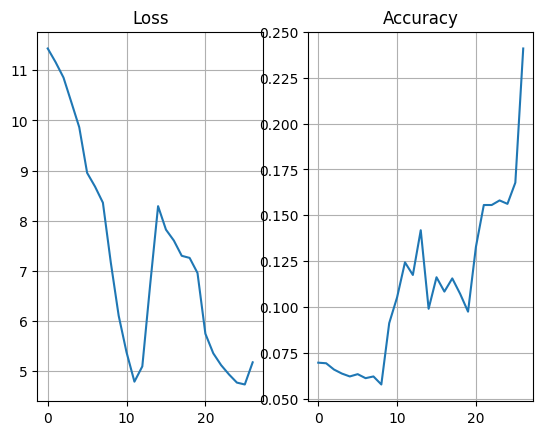

In [13]:
import matplotlib.pyplot as plt

figure, axes = plt.subplots(1, 2)
axes[0].plot(training_history.history['loss'])
axes[0].grid()
axes[0].set_title("Loss")
axes[1].plot(training_history.history['accuracy'])
axes[1].grid()
axes[1].set_title("Accuracy")
plt.show()

# <img src="../images/task.png" width=20 height=20> Task 1.14

## What Do Embeddings Do?

To build an intuitive understanding of what these embeddings do, let's recreate a simplified version of some research that was done at Stanford University. In that research, after training embeddings on a much larger set of data and using embeddings with hundreds more dimensions, they discovered that interesting relationships had been captured. The specific example allowed them to demonstrate that the embeddings had captured the following relationship:

$$
(king - male) + female \approx queen
$$

While this relationship makes intuitive sense, please keep in mind that the network has never seen these words; it has seen arbitrary integer values that were used to look up initially random vectors and try to predict which word or token comes next.

Let's see how well our simple network reproduces this research. Just in case our network didn't find exactly this relationship, we also have some pretrained embeddings that we can load to demonstrate the idea.

Please execute the code in the following cell, which creates a string containing the text values that we need to tokenize:

In [14]:
s = "king queen male female"
tokens = tokenizer.encode(s)
tokens

[10789, 29006, 8762, 8954]

# <img src="../images/task.png" width=20 height=20> Task 1.15

Next, we want to obtain the embedding vectors for each of these tokens. To accomplish this, we want to take the trained *weights*, or parameters, from the Embedding layer and use them directly. To accomplish this we can ask the trained model to give us the weights out of our Embedding layer by calling `get_weights()` on that layer. The return of this is all of the embeddings.

To use these weights, we are going to create a simple model with just one layer, an Embedding layer. Prior to Keras version 3, we could initialize the weights in the embeddings directly. Unfortunately, this is no longer possible. Worse, there is a `set_weights()` call that could be used previously, but it will not work because of what appears to be a logic error in the initial configuration of the new layer.

We can work around this by creating the model and asking it to process data without ever training it. This will force the Embedding layer to be initialized, after which we can use `set_weights()` to configure the weights.

Please execute the following cell to accomplish this:

In [15]:
weights = model.layers[0].get_weights() # Get our trained embeddings

# Define a new model with an ebeddings layer
embed = models.Sequential()
embed.add(layers.Input(shape=(1,)))
embed.add(layers.Embedding(vocab_size, 2))

embed(np.array([1])) # Call the model to force the Embeddings to be intialized to random values

embed.layers[0].set_weights(weights) # Reconfigure the layer to use our trained weights

# <img src="../images/task.png" width=20 height=20> Task 1.16

Our next step is to use these embeddings to look up the vectors associated with each of our tokens. For our purposes, we're going to put these into a dictionary. This is truly just for our purposes; typically, we just use them as tensors directly. Since we want to plot these and then do some arithmetic with them, the dictionary will allow us to do that in a way that is a bit more useful in our case.

Please execute the following cell. This code looks up the vector for each token and puts it into a dictionary where the key is the associated word.

In [16]:
vectors = {s.split()[index]:embed(np.array([token])).numpy().reshape(2) for index, token in enumerate(tokens)}
vectors

{'king': array([0.00301067, 0.00075033], dtype=float32),
 'queen': array([-0.04244237,  0.06703   ], dtype=float32),
 'male': array([-0.37285239,  0.3746048 ], dtype=float32),
 'female': array([-1.3144805,  1.4813176], dtype=float32)}

# <img src="../images/task.png" width=20 height=20> Task 1.17

We need one last item before attempting to plot this data; we need to calculate $king - male + female$. Use the cell below to add a term with the key `'k-m+f'`, the value of which is the computed location for this vector based on the data we have so far.

In [17]:
vectors['k-m+f'] = vectors['king'] - vectors['male'] + vectors['female']

# <img src="../images/task.png" width=20 height=20> Task 1.18

Finally! Let's plot these vectors and see where they fall!

Please execute the code in the following cell to plot these vectors.

0.0030106734 0.0007503303
-0.042442366 0.06703
-0.37285239 0.3746048
-1.3144805 1.4813176
-0.93861747 1.1074631


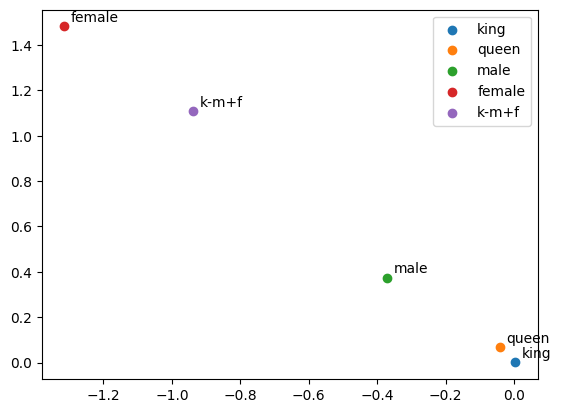

In [18]:
for word, vector in vectors.items():
    print(vector[0], vector[1])
    plt.scatter(vector[0], vector[1], label=word)
    plt.annotate(word,(vector[0]+0.02, vector[1]+0.02)) 
plt.legend()
plt.show()

# <img src="../images/task.png" width=20 height=20> Task 1.19

How did your embeddings turn out? How close is the calculated value of `k-m+f` to the vector for `queen`? If they are not close and you want to prove that this will really happen, you could rerun the lab up to this point four or five times. You should see this eventually emerge.

Why doesn't this happen every time? There are several reasons in our case. First, the embeddings are always initialized with random values. This means that if we train the network multiple times, we will end up in different places. Usually these will be quite close, but they can be quite different.

Another reason for this is that we are only using two embedding dimensions. This is a *very* small number. The network is finding and representing some kind of relationship between the tokens using these vectors, but it might not be the gender relationship we are looking for. Yet another reason is that we are training on a very small amount of data! The more we train on, the more consistent these outputs should be.

Fortunately, we do have some weights that were generated in our lab that we can load in to demonstrate this.  Please execute the following cell, which will load these weights, lookup the vectors, and plot their locations:

0.008858442 -0.03506875
-0.1384355 0.0872327
-0.5546345 0.6912509
-0.70501244 0.8103284
-0.14151949 0.08400875


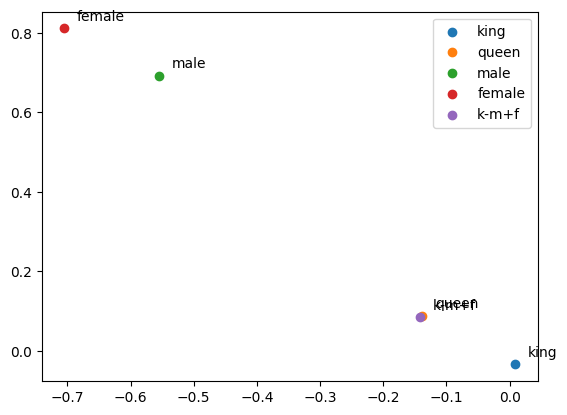

In [19]:
embed.load_weights('../data/embeddings.weights.h5')

vectors = {s.split()[index]:embed(np.array([token])).numpy().reshape(2) for index, token in enumerate(tokens)}
vectors
vectors['k-m+f'] = vectors['king'] - vectors['male'] + vectors['female']
for word, vector in vectors.items():
    print(vector[0], vector[1])
    plt.scatter(vector[0], vector[1], label=word)
    plt.annotate(word,(vector[0]+0.02, vector[1]+0.02)) 
plt.legend()
plt.show()

Wow, that's very impressive! Those two points are right on top of each other, which means that these particular embedding vectors appear to be capturing something related to gender... even though it never sees the actual words involved. The information that it is finding is all resulting from the network learning to do predictions based on the context of the previous word.

While the approach we have used here definitely works, it requires the output layer to perform a softmax function against a set of hundreds of thousands of possibilities. While our embeddings did not take very long to calculate, this has more to do with the fact that we are using a very small number of dimensions; in practice, the approach we have used here is *very* computationally expensive. Let's look at an alternative approach that turns this from a classification problem for one out of hundreds of thousands to a "Yes/No", or boolean, problem. Changing to this design allows us to train far more quickly.

$$softmax([\hat{y}_0 ... \hat{y}_n]) = [\frac{e^{\hat{y}_1}}{\sum_{j=1}^K e^{\hat{y}_j}} ... \frac{e^{\hat{y}_n}}{\sum_{j=1}^K e^{\hat{y}_j}}]$$

We're not going to do this math, but this function must be applied to each of the output neurons. Remember that we have more than 100,000 output neurons, so this will be expensive! Let's briefly examine a clever alternative that is much less expensive: Skipgrams with negative inferencing.

# <img src="../images/task.png" width=20 height=20> Task 1.20

*Skipgrams* are another way of thinking about this problem. We will select some defined number of context words along with what is often called a *center word*, which represents our target, and pass these into the network as input. The network is now trained to predict if that context word and target word are found within our skipgram size of each other in sentences.

> 
> ## Skipgram Aside
>
> There are several different approaches to implementing skipgrams. In our case, we will use the simplest where the target word and a single context word are passed into the network as input. Another approach is to pass in all of the context words simultaneously. Since we are doing this only as a learning exercise and will rely on precomputed embeddings for the rest of our labs, there is no real value in working through coding this added complexity.

If you think about it, this is a pretty clever approach. Rather than have to do a massive amount of computation in the output layer and for that output layer to be more than 100,000 neurons, we now have a single neuron as output. A label of 0 means the words do not appear together and a label of 1 means that they do.

You are likely still trying to figure out where the size of the skipgram comes in, so let's consider an example. Consider the following sentence:

`Let us not seek the Republican answer or the Democratic answer but the right answer`

If we were to decide to use a skipgram size of 3, this would result in the following pairs of words being generated:

<div style="display: inline-block">
    
| Target | Context |
|--------|---------|
|Let | us |
|Let | not |
|Let | seek |
|us | Let |
|us |not |
|us | seek |
|us | the |
|not | Let |
| not | us |
| not | seek |
| not | the |
| not | Republican|
    
</div>

See if you can figure out what is going on in that table. When we define the skipgram size to be 3, we are saying that for each center word, we want to also look at that word in the context of each of the three words to the left and to the right of that center word. When starting off, the word "Let" is the first word, so there's nothing to see to the left of it. Still, we can look at the words "us", "not", and "seek", which are the three words to the right.

So far, this approach looks a great deal like what we have already done; previously we were just trying to predict the next word. How is this different? Again, there are multiple ways to train skipgrams, but our approach will take the target word and a context word as input with the goal of the network learning if those words are related. To do this, we need to generate labels, or correct output values, for the network to train with. For the examples in the table above this is trivial; the labels would be "1", meaning that the words do go together. However, if we only have positive samples (outputs of 1), there really isn't much for the network to learn; it could just generate 1 values without regard for the input values. This is where the trick comes in.

In addition to training with these positive examples, we introduce other context words and label these as zeros! Now the network has something it can learn that is related to the problem and we benefit from the development of target and context embeddings as a side effect. Consider how this data might appear based on the table above:

<div style="display: inline-block">
    
| Target | Context | Label |
|--------|---------|-------|
|Let | us | 1 |
|Let | not | 1 |
|Let | seek | 1 |
|Let | red | 0 |
|Let | pin | 0 |
|Let | sky | 0 |

</div>

Where did the words 'red', 'pin', and 'sky' come from? These are just random words from the corpus. It would be best if we were to more rigorously use words that *never* appear in the context of the target word, but selecting random words will be good enough for us.

## Let's Write Some Code

Begin by copying your existing `generate_data()` generator from the previous approach. After doing this, please make the following changes:

 * Allow for a variable to define the size of the skipgrams we will use.
 * Using that skipgram size, `yield` two values back from your generator:
   - A dictionary with a `'target'` key with a value of the token number for the target and a `'context'` key with the value of the token number for the context.
   - The second value must be a `1`.
   - Return these values for all skipgram combinations to the left and right for each target word.
 * Generate a negative context value for every positive skipgram returned.

In [20]:
import random

skipgram_size = 3
def generate_data():
    files = os.listdir(input_directory)
    files = [i for i in files if i[-4:]=='.txt']
    for file in files:
        print(f'Opening file {file}.')
        with open(os.path.join(input_directory, file), 'r', encoding='utf-8') as f:
            tokens = tokenizer.encode(f.read().lower())
        num_tokens = len(tokens)
        for current_position, token in enumerate(tokens):
            if((current_position < skipgram_size) or (current_position > (num_tokens - skipgram_size))):
                continue
            contexts = tokens[current_position - skipgram_size : current_position] + tokens[current_position+1:current_position+skipgram_size]
            target = token
            for context in contexts:
                yield {'target':target, 'context':context}, 1
            for context in contexts:
                yield {'target':target, 'context':random.randrange(1,vocab_size)}, 0
    return x, y
        

# <img src="../images/task.png" width=20 height=20> Task 1.21

With the generator created, it's now time to turn this into a TensorFlow dataset. You have previously defined a TensorFlow dataset, but this one is a bit more complicated. The code in the cell below defines the dataset as returning a dictionary for the `x` or input values and a single 32 bit integer as the `y` or output value. The naming within the dictionary is pretty important here. The model, which you will soon see, is going to accept two different input values. The naming of the keys in the dictionary here are used to align the input with the named layers in the model.

Please execute the following cell to configure the dataset.

In [21]:
ds = tf.data.Dataset.from_generator(
    generate_data,
    output_signature=(
        {'target':tf.TensorSpec((), tf.int32), 'context':tf.TensorSpec((), tf.int32)}, 
        tf.TensorSpec((),tf.int32)
    )
)

ds = ds.batch(32)

# <img src="../images/task.png" width=20 height=20> Task 1.22

The next step is to build our model and then train it. The code below is necessary to build the model, model design is outside of the scope of this course. Here is a high level overview of what this code does:

 * Create a model using the TensorFlow functional API. The model accepts two inputs:
   - The token ID of the target, or center, word.
   - The token ID of a (potential) context word.
 * Each of these inputs is then translated into a two dimensional embedding space.
 * The pair of embedding vectors for the target and the context is then combined together into a single vector representation.
 * The last layer creates a binary output, seeking to generate values of 0 or 1. 0 means the words do not go together, 1 means that they do.

These layers are then combined into a single model. The remaining code creates a visual representation of the model.

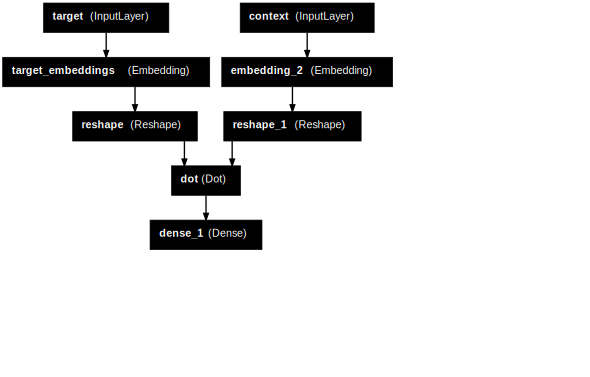

In [22]:
target_input = layers.Input(shape=(1,), name='target')
target = layers.Embedding(vocab_size, 2, name='target_embeddings')(target_input)
target = layers.Reshape((2,))(target)

context_input = layers.Input(shape=(1,), name='context')
context = layers.Embedding(vocab_size, 2)(context_input)
context = layers.Reshape((2,))(context)

combined = layers.Dot(axes=1)([target, context])
output = layers.Dense(1, activation='sigmoid')(combined)

model = models.Model(inputs=[target_input, context_input], outputs=output)

import pydot
from IPython.display import SVG
from keras.utils import model_to_dot

SVG(model_to_dot(model, dpi=48).create(prog='dot', format='svg'))

# <img src="../images/task.png" width=20 height=20> Task 1.23

Finally, we will compile and then train the network using the code in the following cell. In this case, we have configured the cell to train for a very small amount of data since proper training will take hours (or more if we provide more data for the corpus).

Please execute the following cell.

In [23]:
%%time
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# Setting verbose to false to limit output.
training_history = model.fit(ds, epochs=300, steps_per_epoch=200, verbose=False)

Opening file xal.txt.
CPU times: user 6min 21s, sys: 43.7 s, total: 7min 5s
Wall time: 2min 58s


# <img src="../images/task.png" width=20 height=20> Task 1.24

Just to verify that the model is, in fact, learning something, let's look at the training history of the model. Please execute the following cell.

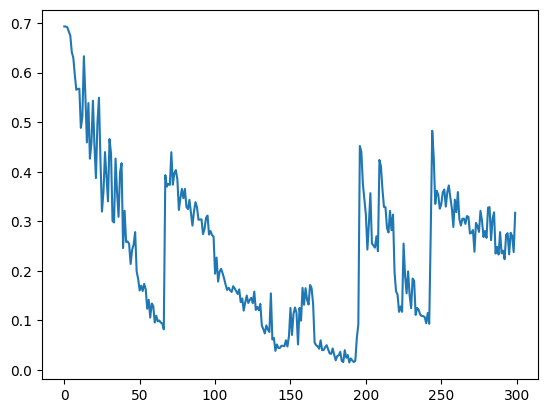

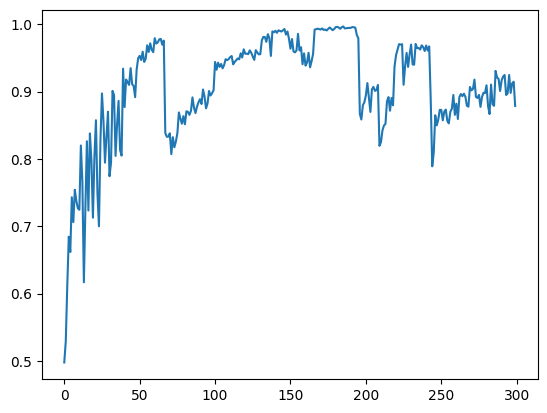

In [24]:
import matplotlib.pyplot as plt

plt.plot(training_history.history['loss'])
plt.show()
plt.plot(training_history.history['accuracy'])
plt.show()

# <img src="../images/task.png" width=20 height=20> Task 1.25

Have a look at the following cell. Everything in it should look familiar. We are, once again, copying the trained word embeddings to a new layer and then using them to find several words in space. After this, we perform some arithmetic involving the vectors and then plot the results. You have seen this same code above. Please run the following cell.

0.17231672 0.14076945
-0.061118495 -0.0059486097
-1.0894852 -1.1856331
-2.093105 -2.014364
-0.83130324 -0.68796146


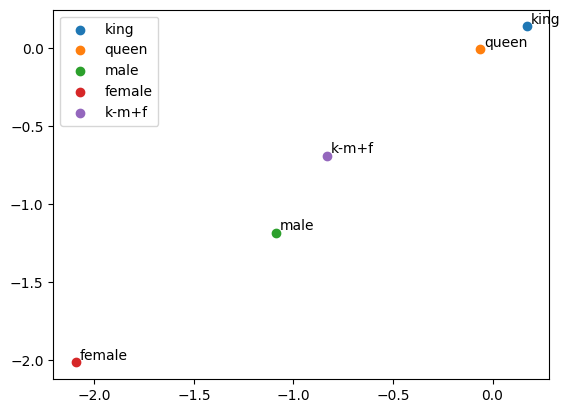

In [25]:
s = "king queen male female"
tokens = tokenizer.encode(s)

weights = model.get_layer('target_embeddings').get_weights() # Get our trained embeddings

# Define a new model with an ebeddings layer
embed = models.Sequential()
embed.add(layers.Input(shape=(1,)))
embed.add(layers.Embedding(vocab_size, 2))

embed(np.array([1])) # Call the model to force the Embeddings to be intialized to random values

embed.layers[0].set_weights(weights) # Reconfigure the layer to use our trained weights

vectors = {s.split()[index]:embed(np.array([token])).numpy().reshape(2) for index, token in enumerate(tokens)}
vectors['k-m+f'] = vectors['king'] - vectors['male'] + vectors['female']

for word, vector in vectors.items():
    print(vector[0], vector[1])
    plt.scatter(vector[0], vector[1], label=word)
    plt.annotate(word,(vector[0]+0.02, vector[1]+0.02)) 
plt.legend()
plt.show()

# <img src="../images/task.png" width=20 height=20> Task 1.26

Finally, let's load some pretrained weights and see if our matrix arithmetic does any better:

-17.127647 17.241043
-19.877506 19.954714
-13.265864 13.206971
-16.689108 16.756748
-20.550892 20.790821


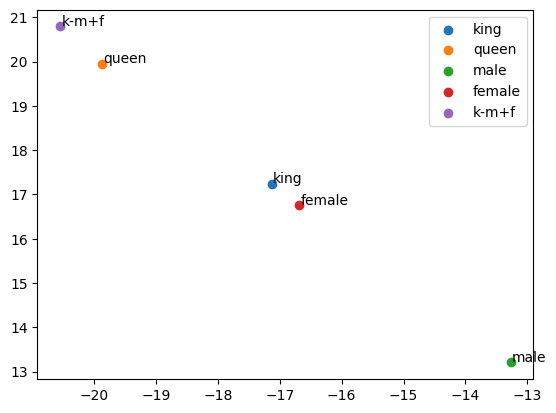

In [26]:
embed.load_weights('../data/skipgram_embeddings.weights.h5')

vectors = {s.split()[index]:embed(np.array([token])).numpy().reshape(2) for index, token in enumerate(tokens)}
vectors
vectors['k-m+f'] = vectors['king'] - vectors['male'] + vectors['female']
for word, vector in vectors.items():
    print(vector[0], vector[1])
    plt.scatter(vector[0], vector[1], label=word)
    plt.annotate(word,(vector[0]+0.02, vector[1]+0.02)) 
plt.legend()
plt.show()

# Conclusion

Let's reflect a bit on what we've discussed in this lab. The big take-aways are that our textual data must be converted into numbers through some means. The most common approach to this problem, especially when it comes to LLMs, is to tokenize the text into chunks and to then learn embedding vector representations of these tokens in the expectation that the various dimensions in the vectors will come to have meaningful information about the semantic and contextual meaning of each word. We also appreciate that the network really does not know what the word is or what it means, it simply knows what the vector representation of that word is.

To examine these ideas we looked at two main ways of training embeddings; attempting to predict the next word given the current input word and skipgrams. We also know that the implementations of these approaches in this lab are not the only ways to implement these particular embeddings training networks.

With these understandings, we are now ready to start looking at how to preprocess our existing text data in such a way as to make it useful for various AI techniques.